<a href="https://colab.research.google.com/github/suresh-venkate/Code_Repositories/blob/main/Deep_Learning/Computer_Vision/Image_Classification/MNIST/MNIST_Classification_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST Dataset Classification - PyTorch version

**Author:** Suresh Venkatesan

* Problem statement: Classify hand-written digits into their respective classes.
* Dataset to be used: [MNIST](https://en.wikipedia.org/wiki/MNIST_database)

# Complete preliminaries

## Connect to Google Drive

In [1]:
### Use this for Google Colab

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import required libraries

In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import datetime
import os
import shutil
import pytz
import math
import requests
import pickle
import gzip
%matplotlib inline

from pathlib import Path
from IPython.core.debugger import set_trace
from tqdm import tqdm

import torch
from torch import nn
from torch.nn import functional as F
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, random_split

# Ignore the warnings
import warnings
warnings.filterwarnings("ignore")

%load_ext tensorboard

# from torchvision.transforms import Lambda, Compose

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


## Define directory paths

In [3]:
# Define base path for TensorBoard Logs directory
tb_logs_base_path = "/content/drive/MyDrive/AI_ML_Folder/Colab_Directory/Model_Outputs/MNIST_PyTorch/TB_Logs/"
os.makedirs(tb_logs_base_path, exist_ok = True) # Don't raise any exception if directory exists
# Define base path for storing all outputs related to model / training
out_base_path = "/content/drive/MyDrive/AI_ML_Folder/Colab_Directory/Model_Outputs/MNIST_PyTorch/Training_Outputs/"
os.makedirs(out_base_path, exist_ok = True) # Don't raise any exception if directory exists
# Define dataset path
dataset_path = "/content/Data/"
os.makedirs(dataset_path, exist_ok = True) # Don't raise any exception if directory exists

# Function Definitions

## Define Function: viz_data_from_dset

In [4]:
def viz_data_from_dset(name, dset, img_dtype, mode, num_images, num_cols, col_size, row_size):

  '''
  Function to plot random images from a PyTorch dataset object along with corresponding labels

  Arguments:
    name: Name to print in title (Training_Set, Test_Set etc.)
    dset: PyTorch dataset object
    img_dtype: Data Type of image array. One of 'Int' or 'Float'
    mode: One of 'grayscale' or 'color'
    num_images: Number of images to plot from input array
    num_cols: Number of columns to use for plotting
    col_size: Size of columns to use for plotting
    row_size: Size of rows to use for plotting

  '''

  num_rows = math.ceil(num_images / num_cols) # Number of rows to use for plotting

  fig = plt.figure(figsize = ((num_cols * col_size), (num_rows * row_size)))
  fig.suptitle('Random sample images from ' + name, fontsize = 40)

  # Generate random sample indices
  samp_index = np.random.randint(low = 0, high = len(dset), size = num_images).tolist()
  
  for ind, value in enumerate(samp_index): # Loop through samp_index
    img, label = dset[value]
    img = img.numpy()
    ax = plt.subplot(num_rows, num_cols, (ind + 1))
    if (mode == 'grayscale'):
      ax.imshow(img.squeeze(), cmap = 'gray') # Plot image in grayscale
    elif (mode == 'color'):
      ax.imshow(img.squeeze()) # Plot image in color
    ax.set_title("Class label is %d" %label, fontsize = 25)
    ax.grid(False)  

  plt.show()  

## Define Function: viz_data_from_array

In [49]:
def viz_data_from_array(name, X, y, X_dtype, mode, num_images, num_cols, col_size, row_size, bm_name = None):

  '''
  Function to plot random images from an input array along with corresponding labels

  Arguments:
    name: Name to print in title (Training_Set, Test_Set etc.)
    X: Image array (should be in (batch, height, width, channel)) format
    y: label array (Raw labels - should not be One-Hot encoded)
    X_dtype: Data Type of image array. One of 'Int' or 'Float'
    mode: One of 'grayscale' or 'color'
    num_images: Number of images to plot from input array
    num_cols: Number of columns to use for plotting
    col_size: Size of columns to use for plotting
    row_size: Size of rows to use for plotting
    bm_name: Name of base model that will be used to undo pre-processing (if required)

  '''

  num_rows = math.ceil(num_images / num_cols) # Number of rows to use for plotting

  fig = plt.figure(figsize = ((num_cols * col_size), (num_rows * row_size)))
  fig.suptitle('Random sample images from ' + name, fontsize = 40)

  # Generate random sample indices
  samp_index = np.random.randint(low = 0, high = X.shape[0], size = num_images).tolist()

  for ind, value in enumerate(samp_index): # Loop through samp_index
    if (X_dtype == 'int'):
      img = (X[value].squeeze()).astype('uint8') # Extract image and force type to uint8
    elif (X_dtype == 'float') :
      if (bm_name == None):
        img = (X[value].squeeze()).astype('float32') # Extract image and force type to float32
      else:
        img = (X[value].squeeze()).astype('float32') # Extract image and force type to float32        
        img = undo_preprocess_data(img, bm_name) # Undo any pre-processing done on image
    label = y[value] # Extract label
    ax = plt.subplot(num_rows, num_cols, (ind + 1))
    if (mode == 'grayscale'):
      ax.imshow(img, cmap = 'gray') # Plot image in grayscale
    elif (mode == 'color'):
      ax.imshow(img) # Plot image in color

    ax.set_title("Class label is %d" %label, fontsize = 25)
    ax.grid(False)  

  plt.show()  

# Dataset - Import, EDA and pre-process

## Import dataset

In [5]:
%%capture

train_dataset = datasets.MNIST(root = dataset_path, train = True, download = True,\
                               transform = ToTensor())
test_dataset = datasets.MNIST(root = dataset_path, train = False, download = True,\
                              transform = ToTensor())

In [6]:
print(f"Number of samples in training set is {len(train_dataset)}")
print(f"Number of samples in test set is {len(test_dataset)}")

Number of samples in training set is 60000
Number of samples in test set is 10000


## Split test set into val and test sets

In [7]:
val_dataset, test_dataset = random_split(test_dataset, [2000, 8000],\
                                         generator = torch.Generator().manual_seed(1234))

In [8]:
print(f"Number of samples in training set is {len(train_dataset)}")
print(f"Number of samples in training set is {len(val_dataset)}")
print(f"Number of samples in test set is {len(test_dataset)}")

Number of samples in training set is 60000
Number of samples in training set is 2000
Number of samples in test set is 8000


## Extract some information about dataset

In [9]:
print(f"List of classes in training set:")
print(f"--------------------------------")
train_dataset.classes

List of classes in training set:
--------------------------------


['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

<b>There are 10 output classes.</b>

In [10]:
print(f"Class to Index mapping in training set:")
print(f"---------------------------------------")
train_dataset.class_to_idx

Class to Index mapping in training set:
---------------------------------------


{'0 - zero': 0,
 '1 - one': 1,
 '2 - two': 2,
 '3 - three': 3,
 '4 - four': 4,
 '5 - five': 5,
 '6 - six': 6,
 '7 - seven': 7,
 '8 - eight': 8,
 '9 - nine': 9}

In [18]:
# Extract first sample from train, val and test dataset and display some properties
# Training Set
print("Training_Set_Information:")
print("-------------------------")
img, label = train_dataset[0]
print(f"Total number of samples: {len(train_dataset)}")
print(f"Type of images: {type(img)}")
print(f"Data Type of images: {img.dtype}")
print(f"Shape of images: {img.shape}")
print(f"Min value of img: {img.min()}")
print(f"Max value of img: {img.max()}")
print(f"Label of first sample: {label}")
print()

# Validation Set
print("Validation_Set_Information:")
print("-------------------------")
img, label = val_dataset[0]
print(f"Total number of samples: {len(val_dataset)}")
print(f"Type of images: {type(img)}")
print(f"Data Type of images: {img.dtype}")
print(f"Shape of images: {img.shape}")
print(f"Min value of img: {img.min()}")
print(f"Max value of img: {img.max()}")
print(f"Label of first sample: {label}")
print()

# Test Set
print("Test_Set_Information:")
print("-------------------------")
img, label = test_dataset[0]
print(f"Total number of samples: {len(test_dataset)}")
print(f"Type of images: {type(img)}")
print(f"Data Type of images: {img.dtype}")
print(f"Shape of images: {img.shape}")
print(f"Min value of img: {img.min()}")
print(f"Max value of img: {img.max()}")
print(f"Label of first sample: {label}")
print()

Training_Set_Information:
-------------------------
Total number of samples: 60000
Type of images: <class 'torch.Tensor'>
Data Type of images: torch.float32
Shape of images: torch.Size([1, 28, 28])
Min value of img: 0.0
Max value of img: 1.0
Label of first sample: 5

Validation_Set_Information:
-------------------------
Total number of samples: 2000
Type of images: <class 'torch.Tensor'>
Data Type of images: torch.float32
Shape of images: torch.Size([1, 28, 28])
Min value of img: 0.0
Max value of img: 1.0
Label of first sample: 6

Test_Set_Information:
-------------------------
Total number of samples: 8000
Type of images: <class 'torch.Tensor'>
Data Type of images: torch.float32
Shape of images: torch.Size([1, 28, 28])
Min value of img: 0.0
Max value of img: 1.0
Label of first sample: 8



<b>The above data shows that the images all three datasets are PyTorch Tensors of size (28, 28)encoded in grayscale float 32 format. Label is a scalar output.</b>

## Get class distribution

In [24]:
# Extract labels of train, val and test datasets
y_train = (train_dataset.targets).numpy()
y_val = (val_dataset.dataset.targets).numpy()
y_test = (test_dataset.dataset.targets).numpy()

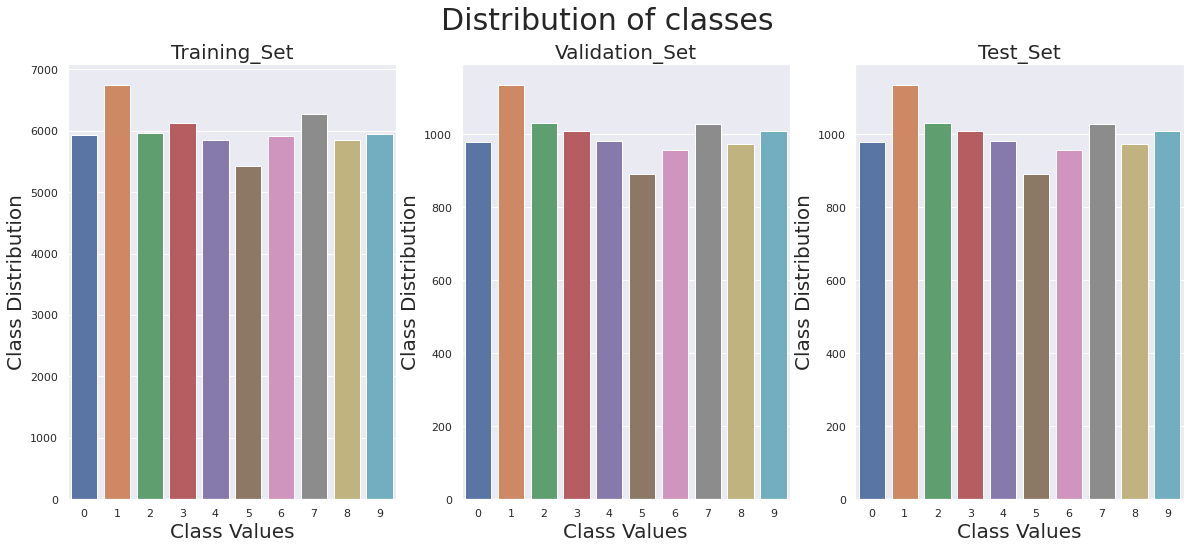

In [25]:
sns.set(color_codes = True)
fig = plt.figure(figsize = (20, 8))
fig.suptitle('Distribution of classes', fontsize = 30)

ax1 = plt.subplot(1, 3, 1)
sns.countplot(y_train)
ax1.set_title('Training_Set', fontsize = 20)
ax1.set_xlabel('Class Values', fontsize = 20)
ax1.set_ylabel('Class Distribution', fontsize = 20)

ax2 = plt.subplot(1, 3, 2)
sns.countplot(y_val)
ax2.set_title('Validation_Set', fontsize = 20)
ax2.set_xlabel('Class Values', fontsize = 20)
ax2.set_ylabel('Class Distribution', fontsize = 20)

ax2 = plt.subplot(1, 3, 3)
sns.countplot(y_test)
ax2.set_title('Test_Set', fontsize = 20)
ax2.set_xlabel('Class Values', fontsize = 20)
ax2.set_ylabel('Class Distribution', fontsize = 20)
plt.show()

In [26]:
# Collate class frequency counts into a dataframe
class_dist_df = pd.DataFrame(np.bincount(y_train), columns=['Training_Set'])
class_dist_df.index.name = 'Class_Label'
class_dist_df['Val_Set'] = np.bincount(y_val)
class_dist_df['Test_Set'] = np.bincount(y_test)

display(class_dist_df)

,Training_Set,Val_Set,Test_Set
Class_Label,,,
0,5923,980,980
1,6742,1135,1135
2,5958,1032,1032
3,6131,1010,1010
4,5842,982,982
5,5421,892,892
6,5918,958,958
7,6265,1028,1028
8,5851,974,974


## Visualize some images from the three datasets

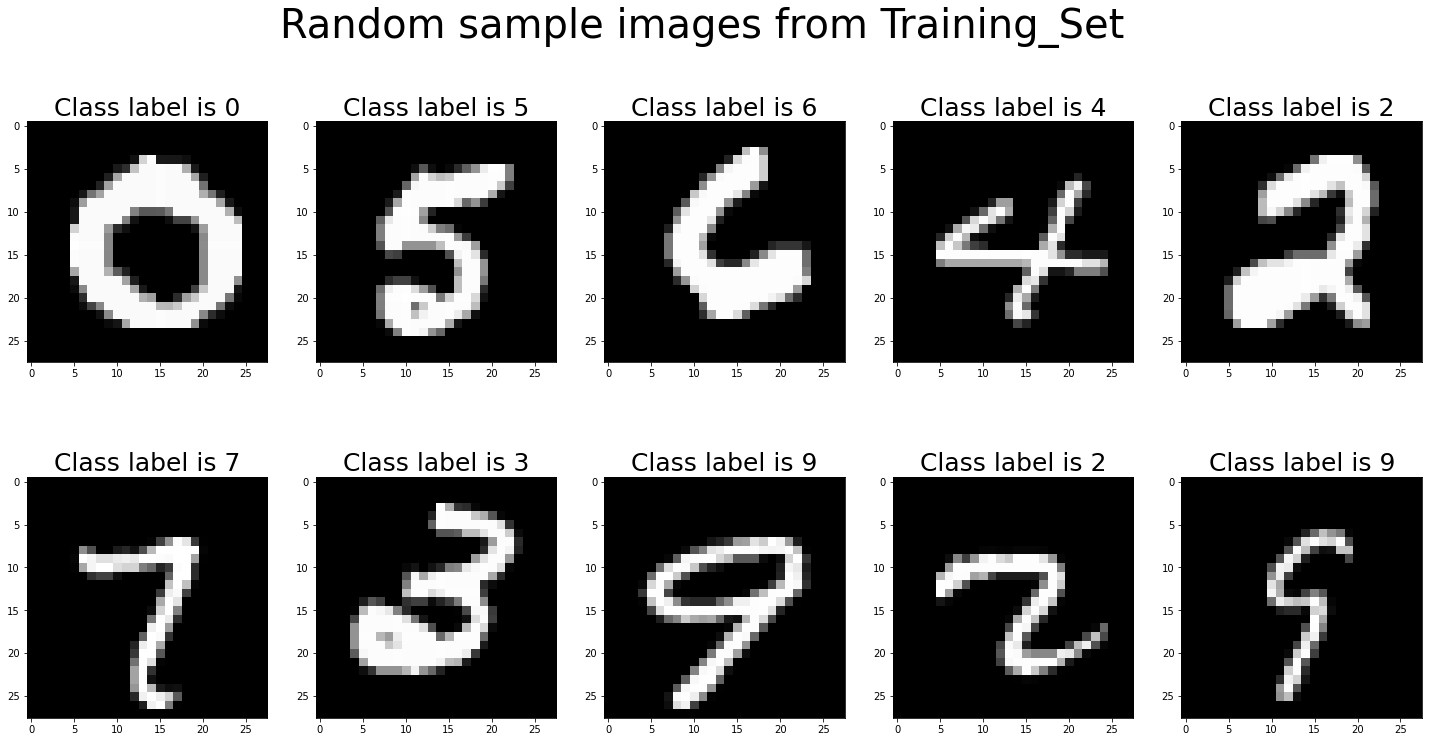

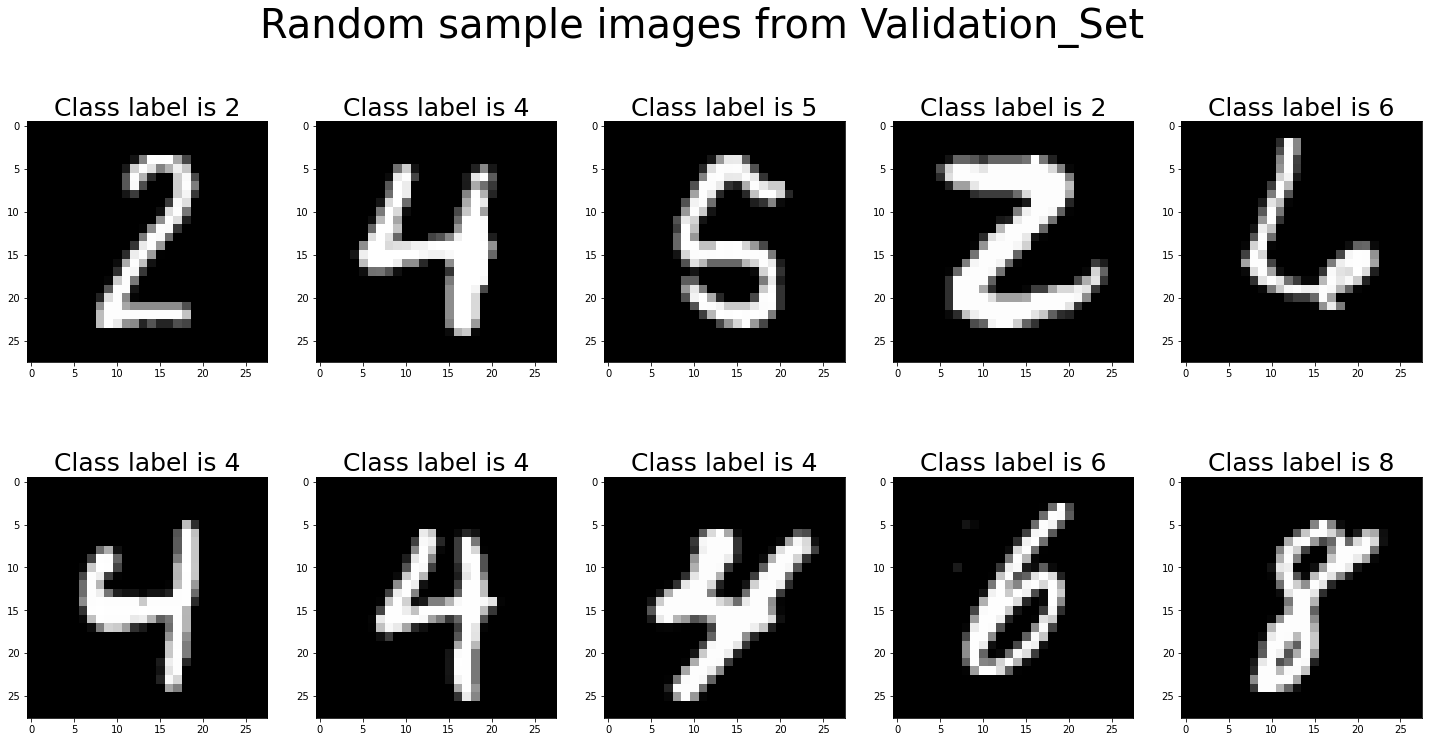

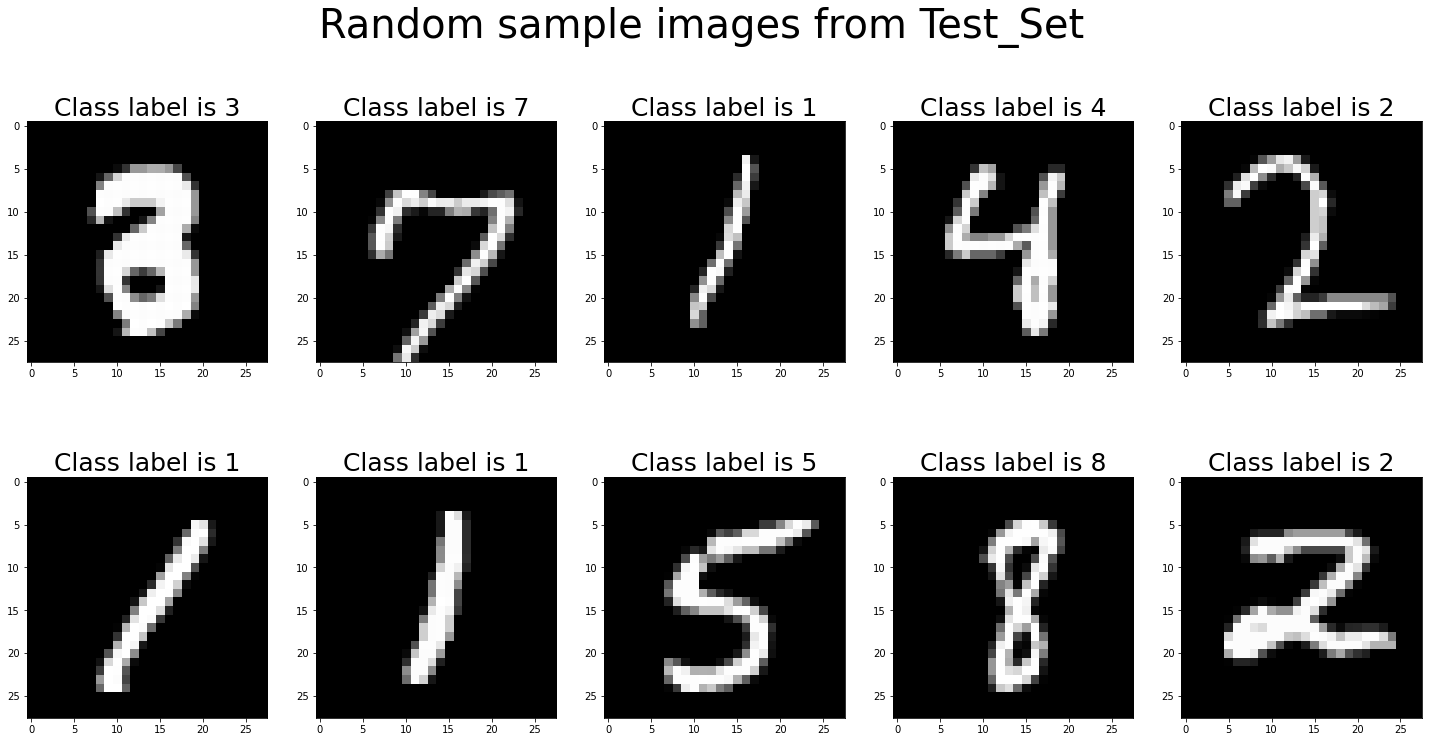

In [12]:
viz_data_from_dset('Training_Set', train_dataset, 'float', 'grayscale', num_images = 10, num_cols = 5,\
                   col_size = 5, row_size = 6)
viz_data_from_dset('Validation_Set', val_dataset, 'float', 'grayscale', num_images = 10, num_cols = 5,\
                   col_size = 5, row_size = 6)
viz_data_from_dset('Test_Set', test_dataset, 'float', 'grayscale', num_images = 10, num_cols = 5,\
                   col_size = 5, row_size = 6)

# Batch generation

## Define batch generators

In [28]:
mod_bat_size = 128 # Batch size to use while model fitting
train_dataloader = DataLoader(train_dataset, mod_bat_size, shuffle = True)
val_dataloader = DataLoader(val_dataset, mod_bat_size, shuffle = True)
test_dataloader = DataLoader(test_dataset, mod_bat_size, shuffle = True)

## Verify batch generators

In [41]:
print("Train Dataloader:")
print("-----------------")
print(f"Total number of batches: {len(train_dataloader)}")
print(f"Size of each batch: {train_dataloader.batch_size}")
print()
print("Val Dataloader:")
print("---------------")
print(f"Total number of batches: {len(val_dataloader)}")
print(f"Size of each batch: {val_dataloader.batch_size}")
print()
print("Test Dataloader:")
print("---------------")
print(f"Total number of batches: {len(test_dataloader)}")
print(f"Size of each batch: {test_dataloader.batch_size}")

Train Dataloader:
-----------------
Total number of batches: 469
Size of each batch: 128

Val Dataloader:
---------------
Total number of batches: 16
Size of each batch: 128

Test Dataloader:
---------------
Total number of batches: 63
Size of each batch: 128


In [48]:
X_batch, y_batch = next(iter(train_dataloader))
print(f"Type of X_batch is {type(X_batch)}")
print(f"Type of y_batch is {type(y_batch)}")
print(f"Shape of X_batch is {X_batch.shape}")
print(f"Shape of y_batch is {y_batch.shape}")
# print(f"Minimum value of X_batch is {X_batch.min()}")
# print(f"Maximum value of X_batch is {X_batch.max()}")
# print(f"Data_Type of X_batch is {X_batch.dtype}")


Type of X_batch is <class 'torch.Tensor'>
Type of y_batch is <class 'torch.Tensor'>
Shape of X_batch is torch.Size([128, 1, 28, 28])
Shape of y_batch is torch.Size([128])


## Visualize the data from generator objects

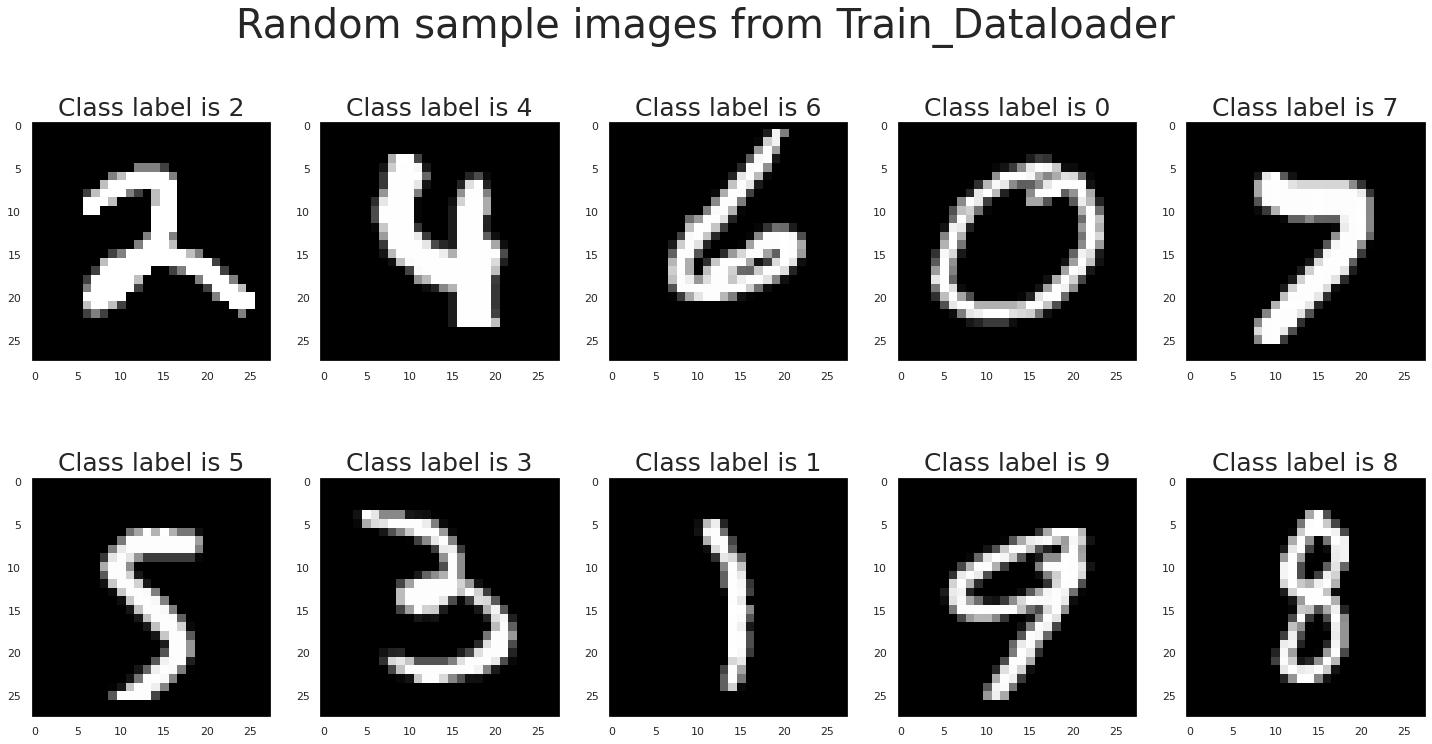

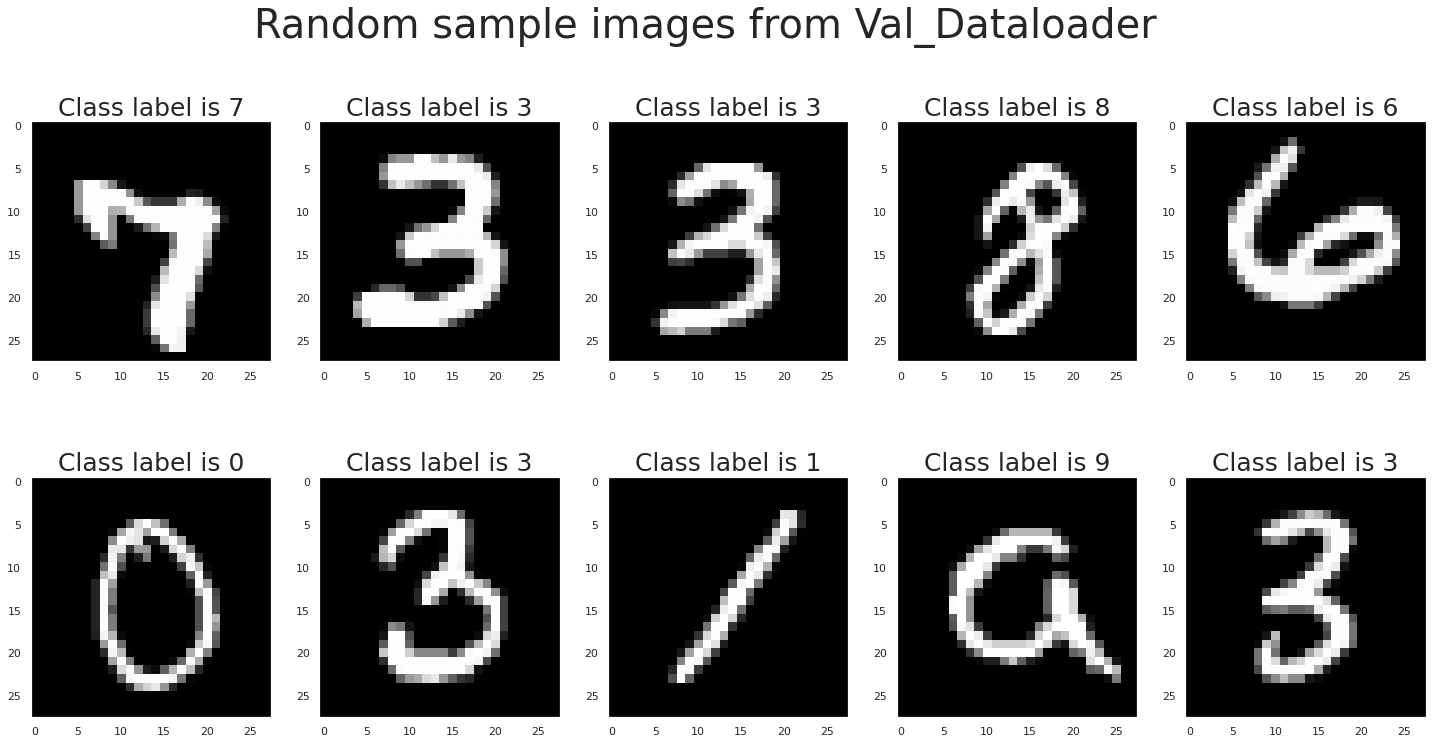

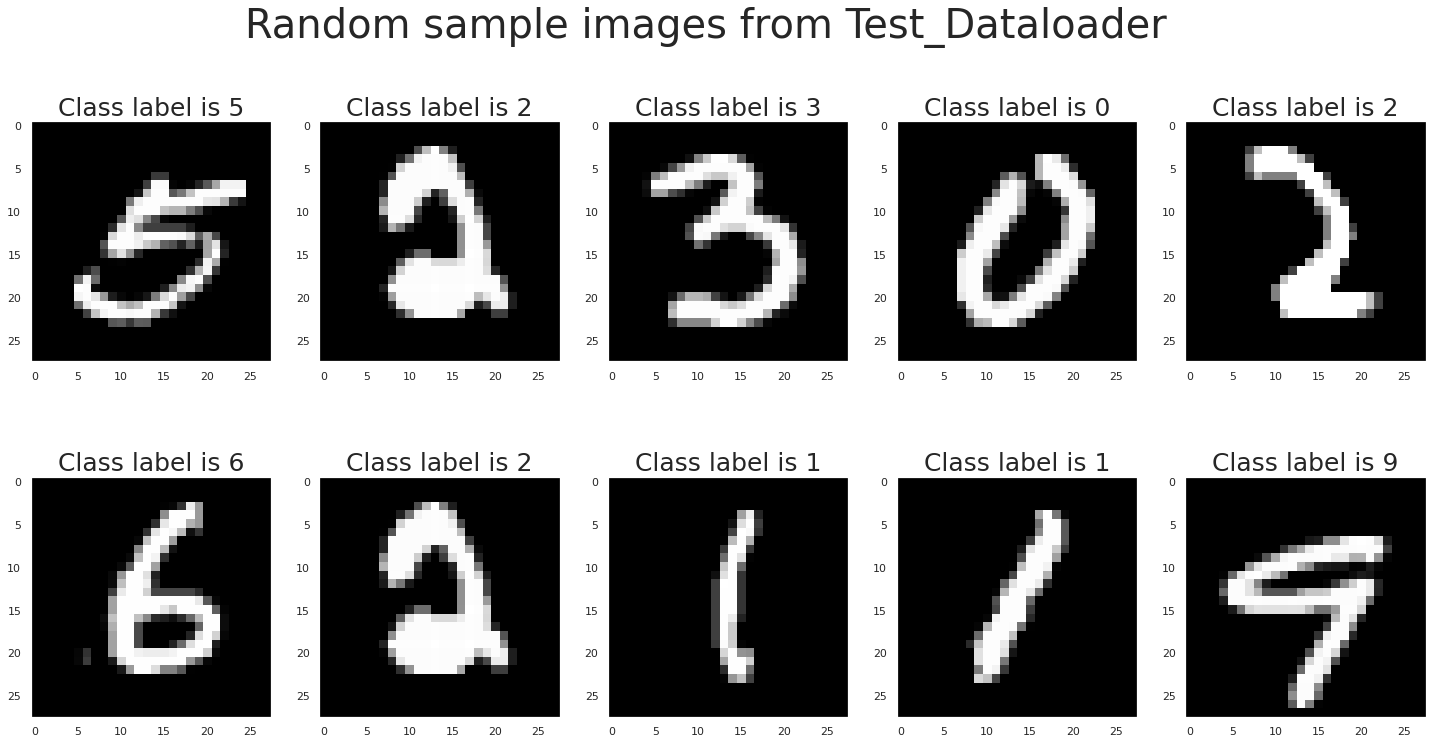

In [60]:
# Generate a batch of data from train_generator
X_batch, y_batch = next(iter(train_dataloader))
X_batch, y_batch = (X_batch.numpy(), y_batch.numpy())
viz_data_from_array('Train_Dataloader', X_batch, y_batch, 'float', 'grayscale', num_images = 10,\
                    num_cols = 5, col_size = 5, row_size = 6)
print("\n\n")
# Generate a batch of data from validation_generator
X_batch, y_batch = next(iter(val_dataloader))
X_batch, y_batch = (X_batch.numpy(), y_batch.numpy())
viz_data_from_array('Val_Dataloader', X_batch, y_batch, 'float', 'grayscale', num_images = 10,\
                    num_cols = 5, col_size = 5, row_size = 6)
print("\n\n")
# Generate a batch of data from test_generator
X_batch, y_batch = next(iter(test_dataloader))
X_batch, y_batch = (X_batch.numpy(), y_batch.numpy())
viz_data_from_array('Test_Dataloader', X_batch, y_batch, 'float', 'grayscale', num_images = 10,\
                    num_cols = 5, col_size = 5, row_size = 6)
print("\n\n")

# Backup

In [70]:
num_batches = len(val_dataloader)
for batch, (X, y) in enumerate(tqdm(val_dataloader)):
  #print(f"Batch {batch+1} of {num_batches}:", X.shape, y.shape)

100%|██████████| 16/16 [00:00<00:00, 88.95it/s]

Batch 1 of 16: torch.Size([128, 1, 28, 28]) torch.Size([128])
Batch 2 of 16: torch.Size([128, 1, 28, 28]) torch.Size([128])
Batch 3 of 16: torch.Size([128, 1, 28, 28]) torch.Size([128])
Batch 4 of 16: torch.Size([128, 1, 28, 28]) torch.Size([128])
Batch 5 of 16: torch.Size([128, 1, 28, 28]) torch.Size([128])
Batch 6 of 16: torch.Size([128, 1, 28, 28]) torch.Size([128])
Batch 7 of 16: torch.Size([128, 1, 28, 28]) torch.Size([128])
Batch 8 of 16: torch.Size([128, 1, 28, 28]) torch.Size([128])
Batch 9 of 16: torch.Size([128, 1, 28, 28]) torch.Size([128])
Batch 10 of 16: torch.Size([128, 1, 28, 28]) torch.Size([128])
Batch 11 of 16: torch.Size([128, 1, 28, 28]) torch.Size([128])
Batch 12 of 16: torch.Size([128, 1, 28, 28]) torch.Size([128])
Batch 13 of 16: torch.Size([128, 1, 28, 28]) torch.Size([128])
Batch 14 of 16: torch.Size([128, 1, 28, 28]) torch.Size([128])
Batch 15 of 16: torch.Size([128, 1, 28, 28]) torch.Size([128])
Batch 16 of 16: torch.Size([80, 1, 28, 28]) torch.Size([80])


## NN from scratch

In [ ]:
# Define weights and bias 
weights = torch.randn(784, 10) / math.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)

In [ ]:
def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1)
def model(xb):
    return log_softmax(xb @ weights + bias)   
def loss_func(input, target):
    return -input[range(target.shape[0]), target].mean() 
def accuracy(out, yb):
    preds = torch.argmax(out, dim = 1)
    return (preds == yb).float().mean()     

In [ ]:
bat_size = 64
X_batch = X_train[0:bat_size]
y_batch = y_train[0:bat_size]
pred_batch = model(X_batch)

print(loss_func(pred_batch, y_batch))
print(accuracy(pred_batch, y_batch))

In [ ]:
n, c = X_train.shape
print(n, c)

In [ ]:
lr = 0.5  # learning rate
epochs = 2  # how many epochs to train for

for epoch in range(epochs):
    for i in range((n - 1) // bat_size + 1):
        #set_trace()
        start_i = i * bat_size
        end_i = start_i + bat_size
        xb = X_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        #print(xb.shape, yb.shape)
        pred = model(xb)
        #print(pred.shape)
        loss = loss_func(pred, yb)
        #print(loss)
        loss.backward()
        #set_trace()
        acc = 100 * accuracy(pred, yb)
        print(f"Epoch: {epoch}, Batch: {i}, Loss:{loss:0.4f}, Accuracy: {acc:0.2f}")
        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()

## Using torch.nn.functionalm

In [ ]:
loss_func = F.cross_entropy

def model(xb):
    return xb @ weights + bias

print(loss_func(model(xb), yb), accuracy(model(xb), yb))

<b>Class distribution is reasonably uniform for all three sets.</b>

## One-hot encode training, validation and testing labels.

In [ ]:
num_classes = 10 # Digits 0 to 9
y_train_ohe = to_categorical(y_train, num_classes = num_classes)
y_val_ohe = to_categorical(y_val, num_classes = num_classes)
y_test_ohe = to_categorical(y_test, num_classes = num_classes)
print("Shape of one-hot encoded training set output is {}" .format(y_train_ohe.shape))
print("Shape of one-hot encoded validation set output is {}" .format(y_val_ohe.shape))
print("Shape of one-hot encoded test set output is {}" .format(y_test_ohe.shape))

## Define Function: plot_img_transf

In [ ]:
def plot_img_transf(X, X_dtype, mode, rot, wid_shift, hgt_shift, shear, zx, zy,\
                    num_cols, col_size, row_size):
  
  '''
  Function to plot various image transformations on an image before applying these transformations
  for data augmentation

  Arguments:
    X: Image array (should be in (batch, height, width, channel)) format
    X_dtype: Data Type of image array. One of 'Int' or 'Float'
    mode: One of 'grayscale' or 'color'
    rot: Extent of clockwise-rotation in degrees
    wid_shift: Extent of wid_shift
    hgt_shift: Extent of height shift
    shear: Shear angle in degrees
    zx: Extent of zoom in x-direction
    zy: Extent of zoom in y-direction
    num_cols: Number of columns to use for plotting
    col_size: Size of columns to use for plotting
    row_size: Size of rows to use for plotting

  '''

  # Generate random sample index
  samp_index = np.random.randint(low = 0, high = X.shape[0], size = 1)[0] 

  img_transf = {} # Dict place-holder to store original and transformed images
  img = X[samp_index] # Extract original image
  img_transf['Original_Image'] = img # Append original image to img_transf dict

  img_transf['Clockwise_Rotation'] = apply_affine_transform(img, theta = rot) # Clockwise rotn
  img_transf['Anti-clockwise Rotation'] = apply_affine_transform(img, theta = -rot) # Anti-clockwise rotn
  img_transf['Left_Shift'] = apply_affine_transform(img, ty = wid_shift) # Left Shift
  img_transf['Right_Shift'] = apply_affine_transform(img, ty = -wid_shift) # Right Shift
  img_transf['Upward_Shift'] = apply_affine_transform(img, tx = hgt_shift) # Upward Shift
  img_transf['Downward_Shift'] = apply_affine_transform(img, tx = -hgt_shift) # Downward Shift
  img_transf['Shear_Left'] = apply_affine_transform(img, shear = shear) # Left shear
  img_transf['Shear_Right'] = apply_affine_transform(img, shear = -shear) # Righ shear  
  img_transf['Zoom_Y'] = apply_affine_transform(img, zx = zx) # Zoom in x-direction  
  img_transf['Zoom_X'] = apply_affine_transform(img, zy = zy) # Zoom in y-direction    

  num_images = len(img_transf) # Total number of images to plot
  num_rows = math.ceil(num_images / num_cols) # Number of rows to use for plotting
  
  fig = plt.figure(figsize = ((num_cols * col_size), (num_rows * row_size)))
  fig.suptitle('Original image along with some affine transformations', fontsize = 40)

  for ind, dict_entry in enumerate(img_transf.items()): # Loop through dictionary items
    key, image = dict_entry[0], dict_entry[1]
    if (X_dtype == 'int'):
      img = (image.squeeze()).astype('uint8') # Extract image and force type to uint8
    elif (X_dtype == 'float') :
      img = (image.squeeze()).astype('float32') # Extract image and force type to float32
    ax = plt.subplot(num_rows, num_cols, (ind + 1))
    if (mode == 'grayscale'):
      ax.imshow(img, cmap = 'gray') # Plot image in grayscale
    elif (mode == 'color'):
      ax.imshow(img) # Plot image in color
    ax.set_title(key, fontsize = 25) # Set key as title
    #ax.grid(False) # Turn off grid

  plt.show()    


## Visualize some image transformations

In [ ]:
plot_img_transf(X_train, 'int', 'grayscale', rot = 30, wid_shift = 5, hgt_shift = 5, shear = 30,\
                zx = 0.8, zy = 0.8, num_cols = 5, col_size = 5, row_size = 6)

## Define base model, target image shape and model batch size

In [ ]:
### The base model defined here (bm_name) will be used to choose the appropriate pre-processing function
### to apply to the input images in the Image Data Generators

### If bm_name = 'VGG16' or 'ResNet50':
###    Only mean shift is applied
###    img_preprocessed = img - [103.939, 116.779, 123.68]
### If bm_name = 'MobileNet' or 'InceptionV3'
###    Image scaled to lie between -1 and +1
###    img_preprocessed = (img / 127.5) - 1
### If bm_name = 'grayscale_model'
###    Image scaled to lie between 0 and +1
###    img_preprocessed = (img / 225.)

# bm_name = 'VGG16'
# bm_name = 'ResNet50'
# bm_name = 'MobileNet'
# bm_name = 'InceptionV3'\
bm_name = 'grayscale_model'

# Define target image size and batch size 
mod_inp_shape = (28, 28, 1) # Define target image size for model input
mod_bat_size = 64 # Batch size to use while model fitting

## Define pre-processing function

In [ ]:
# Define pre-processing and undo pre-processing function
# Appropriate pre-processing functions from Keras are used.

def preprocess_data(img):

  if (bm_name == 'VGG16'):
    return vgg16.preprocess_input(img)
  elif (bm_name == 'ResNet50'):
    return resnet50.preprocess_input(img)
  elif (bm_name == 'MobileNet'):
    return mobilenet.preprocess_input(img)
  elif (bm_name == 'InceptionV3'):
    return inception_v3.preprocess_input(img)
  elif (bm_name == 'grayscale_model'):
    return img/255.

def undo_preprocess_data(img, bm_name):

  if ((bm_name == 'VGG16') or (bm_name == 'ResNet50')):
    mean = [103.939, 116.779, 123.68]
    img[..., 0] += mean[0]
    img[..., 1] += mean[1]
    img[..., 2] += mean[2]
    img = img[..., ::-1].astype('uint8')
  elif ((bm_name == 'MobileNet') or (bm_name == 'InceptionV3')):
    img = ((img + 1) * 127.5).astype('uint8')
  elif (bm_name == 'grayscale_model'):
    img = (img * 255.0).astype('uint8')

  return img

# Models - Build, Train, Tune

## Functions

### Define Model Core

In [ ]:
def model_core(model_dict):
    
    """
    Function to define the model core.
    
    Arguments:
      model_dict - Dictionary with list of keys / values needed to build the model

    Returns:
      model - Model with all layers instantiated
 
    """    
    # Retrieve model dict parameters
    model_arch = model_dict['model_arch'] # Model Architecture
    use_bnorm = model_dict['use_bnorm'] # Boolean, whether to use Batch Norm or not
    use_dropout = model_dict['use_dropout'] # Boolean, whether to use dropout or not
    dropout_rate = model_dict['dropout_rate'] # List containing dropout values for each layer

    ##### Start Model Architecture A
    if (model_arch == 'A'): 
      model = Sequential()

      # Stage-1: Conv2D -> BN -> ReLU -> Dropout -> MaxPool2D ->
      # -> Conv2D -> BN -> ReLU -> Dropout -> MaxPool2D
      model.add(Conv2D(32, (3, 3), input_shape = (28, 28, 1), padding = 'same', name = 'C1'))
      if (use_bnorm): model.add(BatchNormalization(name = 'B1'))
      model.add(Activation('relu', name = 'A1'))
      if (use_dropout): model.add(Dropout(rate = dropout_rate[0], name = 'DR1')) 
      model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2), name = 'M1'))      

      model.add(Conv2D(32, (3, 3), padding = 'same', name = 'C2'))
      if (use_bnorm): model.add(BatchNormalization(name = 'B2'))
      model.add(Activation('relu', name = 'A2'))
      if (use_dropout): model.add(Dropout(rate = dropout_rate[1], name = 'DR2'))
      model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2), name = 'M2'))
      
      # Stage-2: Flatten -> Dense(128, ReLU) -> Dense(64,ReLU) -> Dense(10, Softmax)
      model.add(Flatten(name = 'F1'))
      model.add(Dense(128, activation = 'relu', name = "D1"))
      model.add(Dense(64, activation = 'relu', name = "D2"))      
      model.add(Dense(10, activation = 'softmax', name = "OL"))
  
    ##### End Model Architecture A     
    
    return model

### Verify Model Core

In [ ]:
# Verify model defined above
model_dict = {'model_arch': 'A',
              'use_bnorm': True,
              'use_dropout': True, 
              'dropout_rate': [0.0, 0.0]
              }
temp_model = model_core(model_dict)
temp_model.summary()

### Define Model_Compile

In [ ]:
def model_compile(model, compile_dict):
    
    """
    Function to compile the model
    
    Arguments:
      model - Model instance that needs to be compiled
      compile_dict - Dictionary with list of keys / values needed to compile the model
 
    """    
    # Retrieve compile_dict parameters
    ilr = compile_dict['ilr'] # Initial learning rate to use for learning rate decay scheduler    
    dr = compile_dict['dr'] # Decay rate to use for learning rate decay scheduler    
    ds = compile_dict['ds'] # Decay step to use for learning rate decay scheduler
    redlr_plat = compile_dict['redlr_plat'] # Boolean: If True, implement reduce LR on plateau     

    lr_sch = InverseTimeDecay(ilr, ds, dr) # Inverse Time Decay LR scheduler
    # Define Optimizer
    if (redlr_plat):
      opt = optimizers.Adam(learning_rate = ilr) 
    else:
      opt = optimizers.Adam(learning_rate = lr_sch)
    loss = losses.CategoricalCrossentropy() # Define loss
    met = metrics.CategoricalAccuracy() # Define metric

    # Compile model
    model.compile(optimizer = opt, loss = loss, metrics = met)

### Define Model_Fit

In [ ]:
def model_fit(model, train_dict):
    
    """
    Function to fit the model
    
    Arguments:
      model - Model instance that needs to be trained
      train_dict - Dictionary with list of keys / values needed to fit the model      

    Returns:
      model - Final trained model
      hist - Model training history
    """   

    # Retrieve path parameters
    tb_path = train_dict['tb_path'] # Path to store Tensorboard callback information
    mc_path = train_dict['mc_path'] # File name to use for storing model checkpoints
    
    # Retrieve callback parameters
    mcp_freq = train_dict['mcp_freq'] # Number of batches after which model will be checkpointed    
    early_stop = train_dict['early_stop'] # Boolean: If True, implement early stop
    redlr_plat = train_dict['redlr_plat'] # Boolean: If True, implement reduce LR on plateau  
    lrpl_fac = train_dict['lrpl_fac'] # Factor to use for Reduce LR on Plateau callback
    lrpl_pat = train_dict['lrpl_pat'] # Patience to use for Reduce LR on Plateau callback    

    # Retrieve training parameters
    train_gen = train_dict['train_gen'] # Train Generator to use while fitting
    val_data = train_dict['val_gen'] # Validation Generator to use while fitting
    epochs = train_dict['epochs'] # Number of epochs to train for
    initial_epoch = train_dict['initial_epoch'] # Initial epoch to re-start training from
    train_steps_per_epoch = train_dict['train_steps_per_epoch'] # Number of steps per training epoch
    val_steps = train_dict['val_steps'] # Number of steps before stopping validation
    val_freq = train_dict['val_freq'] # Number of epochs to run before performing a validation run
    verb = train_dict['verb'] # Controls verbosity level of model fit.

    #### Start -  Define callbacks
    # Define path for tensorboard logs
    logdir = os.path.join(tb_path,\
                          datetime.datetime.now(pytz.timezone('Asia/Kolkata')).strftime("%d%m_%H%M"))
    # Define Tensorboard callback
    tensorboard_callback = TensorBoard(logdir, histogram_freq = 0)
    # Define Model Checkpoint callback
    mcp_callback = ModelCheckpoint(filepath = mc_path, save_freq = mcp_freq, verbose = 0)
    # Define Early Stopping callback
    earlystopping_callback = EarlyStopping(monitor = "loss", min_delta = 1e-4, patience = 10,\
                                           mode = "min", verbose = 1)
    # Define 'Reduce learning rate on plateau' callback
    redlr_plat_callback = ReduceLROnPlateau(monitor = "val_loss", factor = lrpl_fac, patience = lrpl_pat,\
                                            verbose = 1, mode = "min", min_delta = 0.0001)
    # Define list of all callbacks
    callback_list = []
    if (tb_path != None): callback_list.append(tensorboard_callback)
    if (mc_path != None): callback_list.append(mcp_callback)
    if (early_stop): callback_list.append(earlystopping_callback)    
    if (redlr_plat): callback_list.append(redlr_plat_callback)
    #### End -  Define callbacks 
    
    #### Start - Model Fit
    hist = model.fit(x = train_gen, validation_data = val_data, epochs = epochs,\
                     initial_epoch = initial_epoch, steps_per_epoch = train_steps_per_epoch,\
                     validation_steps = val_steps, validation_freq = val_freq,
                     callbacks = callback_list, verbose = verb)
    #### End - Model Fit   

    return model, hist

### Define Model_Train

In [ ]:
def model_train(model_dict, compile_dict, train_dict, model = None):
  """
  Function to instantiate (or load) model, compile and fit model.
    
  Arguments:
    model_dict - Dictionary with list of keys / values needed to build the model
    compile_dict - Dictionary with list of keys / values needed to compile the model
    train_dict - Dictionary with list of keys / values needed to train the model
    model - Pre-trained model (Pass this as input only if fit_resume = True and load_model = False)
    
  Returns:
    model - Final trained model
    hist - Model training history
 
  """   
  # Retrieve train_dict parameters
  fit_resume = train_dict['fit_resume'] # Boolean: If True, resume fit from initial epoch
  load_model = train_dict['load_model'] # Boolean: If True, load model from 'fm_path' and resume fit  
  recompile = train_dict['recompile'] # Boolean: If True, recompile model before resuming fit  
  fm_path = train_dict['fm_path'] # File name to use for storing final trained model
  hi_path = train_dict['hi_path'] # File name to use for storing training history

  if (not(fit_resume)): # fit_resume = False => instantiating new model
    print("Instantiating new model...", end = ', ')
    model = model_core(model_dict) # Instantiate new model
    print("Compiling model...", end = ', ')
    model_compile(model, compile_dict) # Compile model
    print("Model Fit started....", end = ', ')    
    model, hist = model_fit(model, train_dict) # Fit model
  else: # fit_resume = True => Proceed with existing model in memory or load model from disk
    if (load_model): # load_model = True => Load model from disk
      print("Loading model from disk...", end = ', ')
      model = models.load_model(fm_path) # Reload model from disk
      if (recompile): # Re-compile model if "recompile" = True
        print("Re-Compiling model...", end = ', ')
        model_compile(model, compile_dict) 
      print("Resuming model fit....", end = ', ')
      model, hist = model_fit(model, train_dict) # Resume model fit
    else: # load_model = False => Proceed with existing model in memory
      if (recompile): # Re-compile model if "recompile" = True
        print("Re-compiling model...", end = ', ')
        model_compile(model, compile_dict)
      print("Resuming model fit....", end = ', ')
      model, hist = model_fit(model, train_dict) # Resume model fit

  # Save final trained model and history to file
  if (fm_path != None): model.save(fm_path, overwrite = True, save_format = 'h5') 
  if (hi_path != None): np.save(hi_path, hist.history)

  return model, hist

## Classes

### Define HyperModel Class (For Hyperparameter Tuning)

In [ ]:
class MyHyperModel(HyperModel):

  def __init__(self, model_dict, compile_dict, hp_dict):
    self.model_dict_tune = model_dict.copy() # Dictionary of default model parameters
    self.compile_dict_tune = compile_dict.copy() # Dictionary of default compilation parameters
    self.hp_dict = hp_dict # Dictionary of hyperparameters to tune

  def build(self, hp):
    hp_list = [] # List placeholder to define all hyperparameters
    for ind in range(len(hp_dict)): # Update hp_list based on hp_dict
      if (hp_dict[ind][0] == 'choice'): hp_list.append(hp.Choice(name = hp_dict[ind][1],\
                                                                 values = hp_dict[ind][2],\
                                                                 ordered = hp_dict[ind][3]))    
    # Set hyperparameters in model_dict_tune
    self.model_dict_tune['dropout_rate'] = [hp_list[0], hp_list[1]]

    model = model_core(self.model_dict_tune) # Instantiate model
    model_compile(model, self.compile_dict_tune) # Compile model    
   
    return model

## Set model_core, model_compile, model_train parameters

In [ ]:
### Define file paths
mod_file_pref = "MA" # Prefix to use for naming files and paths
tb_path = os.path.join(tb_logs_base_path, mod_file_pref) # Tensorboard base path
fm_path = os.path.join(out_base_path, mod_file_pref + "_finalmodel.h5") # Final trained model path
mc_path = os.path.join(out_base_path, mod_file_pref + "_EP{epoch:04d}.h5") # Model checkpoints path
hi_path = os.path.join(out_base_path, mod_file_pref + "_hist.npy") # Training history path

# Set model_dict values
model_dict = {'model_arch': 'A',
              'use_bnorm': True,
              'use_dropout': True, 
              'dropout_rate': [0.0, 0.0]
              }
# Set compile_dict values
compile_dict = {'ilr': 1e-4, # Initial learning rate to use for learning rate decay scheduler    
                'dr': 1, # Decay rate to use for learning rate decay scheduler
                'ds': (len(train_generator) * 10), # Decay rate to use for learning rate decay scheduler
                'redlr_plat': False, # Boolean: If True, implement reduce LR on plateau  
               }
# Set train_dict values               
train_dict = {'fit_resume': False, # Boolean: If True, resume fit from initial epoch
              'load_model': False, # Boolean: If True, load model from 'fm_path' and resume fit
              'recompile': False, # Boolean: If True, recompile model before resuming fit
              'train_gen': train_generator, # Train generator to use while fitting
              'val_gen': val_generator, # Validation generator to use while fitting
              'epochs': 30, # Number of epochs to train for              
              'initial_epoch': 0, # Initial epoch to start from              
              'train_steps_per_epoch': len(train_generator), # No. of steps per epoch
              'val_steps': len(val_generator), # No. of steps before stopping eval of val set
              'val_freq': 1, # Number of epochs to run before performing a validation run
              'verb': 0, # Controls verbosity level of model fit.
              'mcp_freq': (len(train_generator) * 500), # Checkpoint model after mcp_freq batches
              'early_stop': False, # Boolean: If True, implement early stop
              'redlr_plat': compile_dict['redlr_plat'], # Boolean: If True, implement reduce LR on plateau
              'lrpl_fac': 0.5, # Factor to use for Reduce LR on Plateau callback
              'lrpl_pat': 10, # Patience to use for Reduce LR on Plateau callback              
              'tb_path': tb_path, # Path to store Tensorboard callback information
              'mc_path': mc_path, # File name to use for storing model checkpoints
              'fm_path': fm_path, # File name to use for storing final trained model
              'hi_path': hi_path, # File name to use for storing training history
              }

print(tb_path)
print(mc_path)
print(fm_path)
print(hi_path)

## Launch Tensorboard

In [ ]:
%tensorboard --logdir {tb_logs_base_path}

## Train Model

In [ ]:
# Get start time of run and display it
start_time = datetime.datetime.now(pytz.timezone('Asia/Kolkata'))
print("Started at %s" %(start_time.strftime("%H:%M:%S")), end = '; ')

# Instantiate, compile and fit model
if (train_dict['fit_resume'] and not(train_dict['load_model'])):
  model, hist = model_train(model_dict, compile_dict, train_dict, model)
else:
  model, hist = model_train(model_dict, compile_dict, train_dict)

# Get end time of run and display elapsed time
end_time = datetime.datetime.now(pytz.timezone('Asia/Kolkata'))
elap_time = ((end_time - start_time).total_seconds())/60
print("\nCompleted at %s. Elapsed time = %0.2f minutes." %(end_time.strftime("%H:%M:%S"), elap_time))

## Hyperparameter Tuning

In [ ]:
project_name = "MA_DR_Tune" # Directory to store results of hyperparameter tuning

# Define hyperparameters in hp_dict
hp_dict = {0: ['choice', 'Dropout_0', [0.2, 0.3, 0.4, 0.5], True],
           1: ['choice', 'Dropout_1', [0.2, 0.3, 0.4, 0.5], True],
           }

# Instantiate hypermodel           
hypermodel = MyHyperModel(model_dict, compile_dict, hp_dict) 

# Instantiate Tuner
tuner = kt.RandomSearch(hypermodel, objective = 'val_categorical_accuracy', max_trials = 2,\
                        seed = 1234, directory = kt_logs_base_path, project_name = project_name)

# Display Hyperparameter Search Space
tuner.search_space_summary()

In [ ]:
# Run hyperparameter search
tuner.search(x = train_dict['train_gen'], validation_data = train_dict['val_gen'],\
             epochs = 2, steps_per_epoch = train_dict['train_steps_per_epoch'],\
             validation_steps = train_dict['val_steps'], verbose = 1)

best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0].get_config()['values']
print()
print("Best Hyperparameters:")
print("---------------------")
print(best_hps)

# best_hps_dict = tuner.get_best_hyperparameters(num_trials = 1)[0]
# best_model = tuner.hypermodel.build(best_hps_dict)
# best_model.summary()

# Results Summary

## Define Functions

### Function: get_model

In [ ]:
def get_model(mod_file_prefix, print_summary = False):
  '''
  Function to return required paths, loaded model and print model summary

  Arguments:
    mod_file_prefix: # Prefix of model file name
    print_summary: Boolean. If True, print model summary
  '''
  fm_path = os.path.join(out_base_path, mod_file_pref + "_finalmodel.h5") # Final model path
  hi_path = os.path.join(out_base_path, mod_file_pref + "_hist.npy") # History file path
  
  # Load model with final trained weights
  model = models.load_model(fm_path) 
  
  # Print model summary
  if (print_summary):
    display(model.summary())

  return fm_path, hi_path, model

### Function: plot_lc

In [ ]:
def plot_lc(mod_file_pref, hi_path, hist_plot_dict, num_cols, col_size, row_size):
  '''
  Function to plot learning curves 

  Arguments:
    hi_path: path of history file
    hist_plot_dict: Dictionary containing items to plot
    num_cols: Number of columns to use for plotting
    col_size: Column width to use while plotting
    row_size: Row width to use while plotting
  '''
  hist_model = np.load(hi_path, allow_pickle = 'TRUE').item()
  
  num_plots = len(hist_plot_dict)
  num_rows = math.ceil(num_plots / num_cols) # Number of rows to use for plotting

  fig = plt.figure(figsize = ((num_cols * col_size), (num_rows * row_size)))
  fig.suptitle(mod_file_pref + " Learning Curves", fontsize = 20)

  for ind, value in enumerate(hist_plot_dict.items()):
    ax = plt.subplot(num_rows, num_cols, (ind + 1))
    for key in value[1][0].keys():
      ax.plot(hist_model[key], value[1][0][key][0], label = value[1][0][key][1])     
      ax.set_title(value[1][1], fontsize = 20)
      ax.set_ylabel(value[1][2], fontsize = 20)
      ax.set_xlabel(value[1][3], fontsize = 20)
      ax.grid(b = True)
      ax.legend(fontsize = 15)

### Function: plot_cm

In [ ]:
def plot_cm(train_gen, val_gen, test_gen, y_train, y_val, y_test, row_size, col_size):

  '''
  Function to plot confusion matrices for train, val and test sets

  Arguments:
    train_gen: Train generator without augmentation and shuffling
    val_gen: Validation generator without augmentation and shuffling
    test_gen: Test generator without augmentation and shuffling
    y_train: Ground-truth training set labels
    y_val: Ground-truth validation set labels
    y_test: Ground-truth testing set labels
    row_size: Row size to use for plotting
    col_size: Column size to use for plotting
  '''

  # Obtain predicted labels for training, validation and testing sets
  y_train_pred = np.argmax(model.predict(x = train_gen, steps = len(train_gen), verbose = 0), axis = 1)
  y_val_pred = np.argmax(model.predict(x = val_gen, steps = len(val_gen), verbose = 0), axis = 1)
  y_test_pred = np.argmax(model.predict(x = test_gen, steps = len(test_gen), verbose = 0), axis = 1)    

  # Generate confusion matrices
  cm_train = tf.math.confusion_matrix(y_train, y_train_pred).numpy()
  cm_val = tf.math.confusion_matrix(y_val, y_val_pred).numpy()  
  cm_test = tf.math.confusion_matrix(y_test, y_test_pred).numpy()

  # Convert confusion matrices to pandas DF
  index = [('A' + str(a)) for a in list(np.unique(y_train).astype(np.int))]
  columns = [('P' + str(a)) for a in list(np.unique(y_train).astype(np.int))]
  cm_train_df = pd.DataFrame(cm_train, index = index, columns = columns)
  cm_val_df = pd.DataFrame(cm_val, index = index, columns = columns)  
  cm_test_df = pd.DataFrame(cm_test, index = index, columns = columns)

  # Plot confusion matrices
  fig = plt.figure(figsize = (col_size, (3 * row_size)))

  ax1 = plt.subplot(3, 1, 1)
  sns.heatmap(cm_train_df, annot_kws = {"fontsize": 15}, linewidths = 1,\
              linecolor = 'black', cmap = 'Blues', annot = True ,fmt = 'g',\
              cbar = False, ax = ax1)
  ax1.set_title("Confusion Matrix for Training set", fontsize = 25)
  ax1.tick_params(labelsize = 20)

  ax2 = plt.subplot(3, 1, 2)
  sns.heatmap(cm_val_df, annot_kws = {"fontsize": 15}, linewidths = 1,\
              linecolor = 'black', cmap = 'Blues', annot = True ,fmt = 'g',\
              cbar = False, ax = ax2)
  ax2.set_title("Confusion Matrix for Validation set", fontsize = 25)
  ax2.tick_params(labelsize = 20)

  ax3 = plt.subplot(3, 1, 3)
  sns.heatmap(cm_test_df, annot_kws = {"fontsize": 15}, linewidths = 1,\
              linecolor = 'black', cmap = 'Blues', annot = True ,fmt = 'g',\
              cbar = False, ax = ax3)
  ax3.set_title("Confusion Matrix for Test set", fontsize = 25)
  ax3.tick_params(labelsize = 20)  

  plt.show() 

### Function: predict_and_plot

In [ ]:
def predict_and_plot(X, y, samp_indices, model, num_cols, col_size, row_size, fig_title):

  '''
  Function to make predictions on a subset of data and plot images with actual
  and predicted labels

  Arguments:
    X: Input image array
    y: Input label array
    samp_indices: Indices from X to be plotted
    model: Model instance to use for making predictions
    num_cols: Number of columns to use for plotting
    col_size: Size of columns to use for plotting
    row_size: Size of rows to use for plotting
    fig_title: Title to use for overall figure
  ''' 

  num_rows = math.ceil(len(samp_indices) / num_cols) # Number of rows to use for plotting
  fig = plt.figure(figsize = ((num_cols * col_size), (num_rows * row_size)))
  fig.suptitle(fig_title, fontsize = 40)

  for ind, samp_ind in enumerate(samp_indices):
    img = np.expand_dims(X[samp_ind].copy(), axis = 0)
    img = preprocess_data(img)
    y_pred = np.argmax(model.predict(img), axis = 1)[0]
    ax = plt.subplot(num_rows, num_cols, (ind + 1))
    ax.text(0.5, 1.35, f"Sample index is {samp_ind}", transform = ax.transAxes,\
            horizontalalignment = 'center', verticalalignment = 'center',\
            color = 'black', fontfamily = 'sans-serif', fontsize = '22')    
    ax.text(0.5, 1.20, f"Actual label is {y[samp_ind]}", transform = ax.transAxes,\
            horizontalalignment = 'center', verticalalignment = 'center',\
            color = 'black', fontfamily = 'sans-serif', fontsize = '22')    
    ax.text(0.5, 1.05, f"Predicted label is {y_pred}", transform = ax.transAxes,\
            horizontalalignment = 'center', verticalalignment = 'center',\
            color = 'black', fontfamily = 'sans-serif', fontsize = '22')    
    ax.imshow(img[0].squeeze(), cmap = 'gray')

  plt.show()

## Model_1: CNN_1

* Input shape = (28 x 28 x 1)
* Layers:

    * Conv2D: Filters = 32, Kernel size = (3 x 3). Padding = 'valid', stride = (1 x 1). Output shape = (26 x 26 x 32). 
    * Activation = 'ReLU'
    * Conv2D: Filters = 32, Kernel size = (3 x 3). Padding = 'valid', stride = (1 x 1). Output shape = (24 x 24 x 32)
    * Activation = 'ReLU'
    * Flatten: Output shape = (18432 x 1)
    * Dense: Output shape = (128 x 1)
    * Activation = 'ReLU'
    * Dense: Output shape = (10 x 1)
    * Activation = 'Softmax'


### Define file paths

In [ ]:
mod_file_pref = "MA"
fm_path, hi_path, model = get_model("MA", False)

### Plot learning curves

In [ ]:
hist_plot_dict = {0: [{'loss': ['r-', 'Training_Set_Loss'],
                       'val_loss': ['b-', 'Validation_Set_Loss']},
                      'Loss vs. #Epoch', 'Loss', '# Epochs'],
                  1: [{'categorical_accuracy': ['r-', 'Training_Set_Accuracy'],
                      'val_categorical_accuracy': ['b-', 'Validation_Set_Accuracy']},
                      'Accuracy vs. #Epoch', 'Accuracy', '# Epochs']
                  }
plot_lc(mod_file_pref, hi_path, hist_plot_dict, 2, 7, 7)

### Evaluate model on training and test sets

In [ ]:
# Evaluate model on training set
res = model.evaluate(x = train_generator, steps = len(train_generator), verbose = 0, return_dict = True)
print("Training set loss is %0.4f" % res['loss'])
print("Training set accuracy is %0.2f %%" % (100 * res['categorical_accuracy']))
print()
# Evaluate model on validation set
res = model.evaluate(x = val_generator, steps = len(val_generator), verbose = 0, return_dict = True)
print("Validation set loss is %0.4f" % res['loss'])
print("Validation set accuracy is %0.2f %%" % (100 * res['categorical_accuracy']))
print()
# Evaluate model on test set
res = model.evaluate(x = test_generator, steps = len(test_generator), verbose = 0, return_dict = True)
print("Test set loss is %0.4f" % res['loss'])
print("Test set accuracy is %0.2f %%" % (100 * res['categorical_accuracy']))

### Plot Confusion matrix

In [ ]:
# Regenerate train, val and test generators without augmentation and shuffling
train_datagen_cm = ImageDataGenerator(preprocessing_function = preprocess_data)
val_datagen_cm = ImageDataGenerator(preprocessing_function = preprocess_data)
test_datagen_cm = ImageDataGenerator(preprocessing_function = preprocess_data)

train_gen_cm = train_datagen_cm.flow(X_train, y_train_ohe, batch_size = mod_bat_size,\
                                           shuffle = False)
val_gen_cm = val_datagen_cm.flow(X_val, y_val_ohe, batch_size = mod_bat_size,\
                                           shuffle = False)
test_gen_cm = test_datagen_cm.flow(X_test, y_test_ohe, batch_size = mod_bat_size,\
                                           shuffle = False)

plot_cm(train_gen_cm, val_gen_cm, test_gen_cm, y_train, y_val, y_test, 8, 8)

### Make Predictions

In [ ]:
### Use this to plot random images from a particular set
# samp_indices = np.random.randint(low = 0, high = X_train.shape[0], size = 10)
# fig_title = 'Random Images from training set'

### Use this to plot random images corresponding to a particular label
# label = 5
# full_indices = np.nonzero(y_train == label)[0]
# samp_indices = list(np.random.choice(full_indices, size = 10))
# fig_title = f'Images from training set with actual label = {label}'

### Use this to plot random images corresponding to incorrect predictions from a particular set
# y_train_pred = np.argmax(model.predict(x = train_gen_cm, steps = len(train_gen_cm), verbose = 0),\
#                          axis = 1)
# full_indices = np.nonzero(y_train != y_train_pred)[0]
# samp_indices = list(np.random.choice(full_indices, size = 10))
# fig_title = 'Images from training set corresponding to incorrect predictions'

### Use this to plot random images corresponding to incorrect predictions of a particular label
y_train_pred = np.argmax(model.predict(x = train_gen_cm, steps = len(train_gen_cm), verbose = 0),\
                         axis = 1)
label = 8
full_indices = np.nonzero(y_train == label)[0]
full_indices = full_indices[np.nonzero(y_train[full_indices] != y_train_pred[full_indices])]
samp_indices = list(np.random.choice(full_indices, size = 10))
fig_title = f'Images from training set with incorrect predictions of label = {label}'

# Predict and plot
predict_and_plot(X_train, y_train, samp_indices, model, 5, 5, 7, fig_title)